<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
from IPython.display import clear_output

In [2]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
clear_output()

In [3]:
!if [ -d deepul-24spring-solutions ]; then rm -Rf deepul-24spring-solutions; fi
!git clone https://github.com/Yjejuy/deepul-24spring-solutions.git
!pip install ./deepul-24spring-solutions
clear_output()

In [1]:
from deepul.hw2_helper import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from typing import Type, Any, Callable, Union, List, Optional
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

@torch.no_grad()
def test_loss(model, test_loader, loss_dim=1) -> Union[float, List[float]]:
    '''
    Take either a DataLoader, return the average loss over the whole test set.
    test_loader should be generated in the device.
    '''
    model.eval()
    loss = [0 for _ in range(loss_dim)]
    for count, X in enumerate(test_loader):
        X = X.to(device)
        tmp = model.loss(X) # Assume loss() returns a dict or a tuple
        if isinstance(tmp, dict):
            tmp = list(tmp.values())
        elif isinstance(tmp, torch.Tensor):
            tmp = [tmp]
        for i in range(loss_dim):
            loss[i] += tmp[i].item()
    if loss_dim == 1:
        return loss[0] / (count + 1)
    else:
        return [l / (count + 1) for l in loss]

import time
class timer:
    def __init__(self):
        self.start_time = time.time()

    def start(self, seed=42):
        self.start_time = time.time()
        set_seed(seed)

    def end(self):
        end_time = time.time()
        print(f'finished in {end_time - self.start_time:.4f}s')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

timer = timer()

def preprocessor(rgbscale, bias):
    # check x is a tensor or numpy array
    def preprocess(x: np.ndarray)  -> torch.Tensor:
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.permute(0, 3, 1, 2)
        x = (x + bias) * rgbscale
        return x
    return preprocess

def postprocessor(rgbscale, bias):
    # check x is a tensor or numpy array
    def postprocess(x: torch.Tensor)-> np.ndarray:
        if isinstance(x, torch.Tensor):
            x = x.cpu().detach().numpy()
        x = np.clip(x / rgbscale - bias, 0, 255).astype(np.uint8)
        if x.shape[1] == 3:
            x = x.transpose(0, 2, 3, 1)
        return x
    return postprocess

def pair_concate(x, y):
    result = np.zeros(np.concatenate([x, y], axis=0).shape)
    result[::2] = x
    result[1::2] = y
    return result

cuda


# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


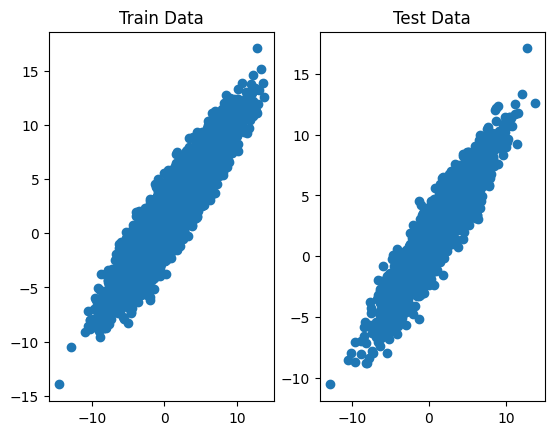

Dataset 2


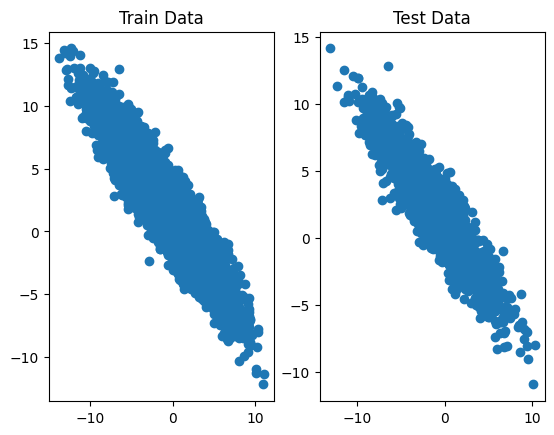

In [5]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

Construct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, z_dim=2, hidden_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2) # 2 for mean and std
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * 2)
        )

    def encode(self, x):
        z_params = self.encoder(x)
        z_mean, z_log_var = z_params.chunk(2, dim=-1)
        return z_mean, z_log_var

    def decode(self, z):
        x_params = self.decoder(z)
        x_mean, x_log_var = x_params.chunk(2, dim=-1)
        return x_mean, x_log_var

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean, x_log_var = self.decode(z)
        x_hat = self.reparameterize(x_mean, x_log_var)
        return x_hat, x_mean, x_log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def loss(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean, x_log_var = self.decode(z)
        # KL divergence between approximate posterior and prior
        kl = 0.5 * torch.sum(z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1, dim=-1)
        # reconstruction loss
        pi_term = torch.tensor(np.log(2 * np.pi), dtype=x.dtype, device=x.device)
        # test whether this work in GPU: nll = 0.5 * torch.sum((x - x_mean) ** 2 / torch.exp(2 * x_log_std) + 2 * x_log_std + np.log(2 * np.pi), dim=-1)
        rcl = 0.5 * torch.sum((x - x_mean) ** 2 / torch.exp(x_log_var) + x_log_var + pi_term, dim=-1)
        kl, rcl = kl.mean(), rcl.mean()
        nelbo = kl + rcl # negative elbo
        return nelbo, rcl.mean(), kl.mean()

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn(n, 2).to(device)
        x_mean, x_log_std = self.decode(z)
        return self.reparameterize(x_mean, x_log_std), x_mean

In [7]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """
    lr, epochs, batch_size = 0.01, 10, 128
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]

    for epoch in range(epochs):
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo, kl, rcl = model.loss(x)
            nelbo.backward()
            optimizer.step()
            record_train.append([nelbo.item(), kl.item(), rcl.item()])
        record_test.append(test_loss(model, test_loader, loss_dim=3))

    samples_noisy, samples_clean = model.sample(1000)

    return np.array(record_train), np.array(record_test), samples_noisy.cpu().numpy(), samples_clean.cpu().numpy()


    """ YOUR CODE HERE """

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.5134, Recon Loss: 2.8580, KL Loss: 1.6553


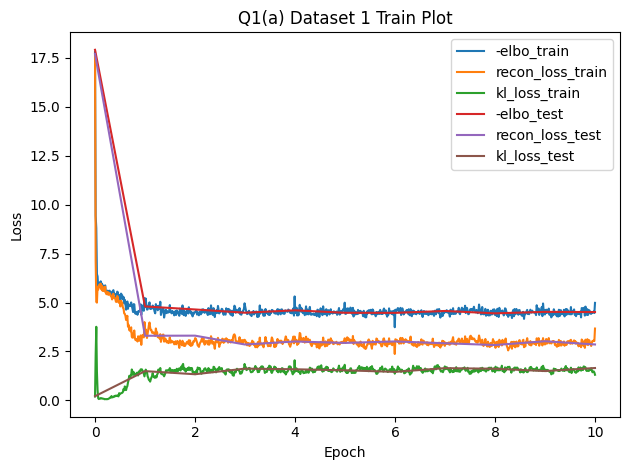

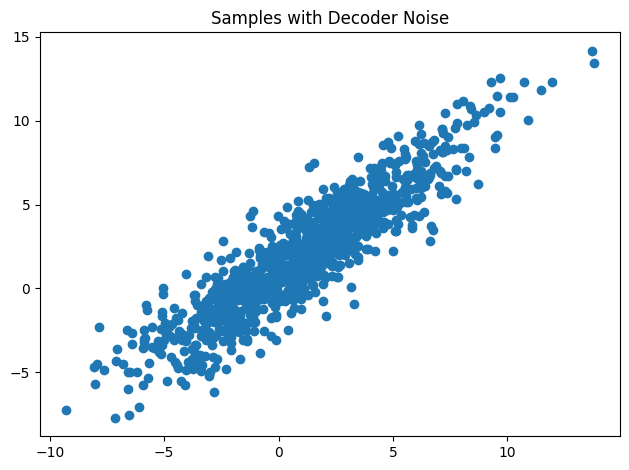

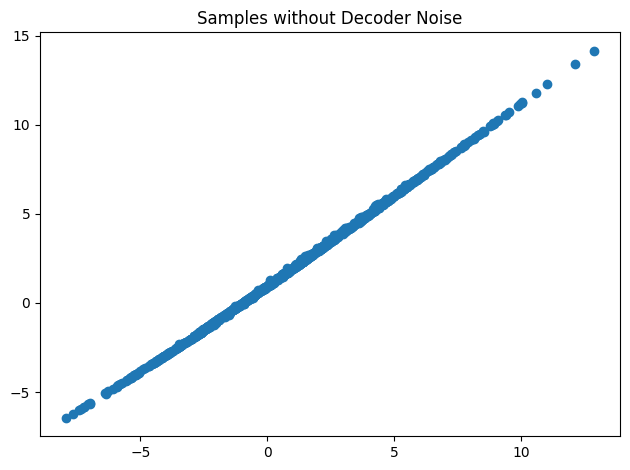

In [8]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.5033, Recon Loss: 2.9735, KL Loss: 1.5298


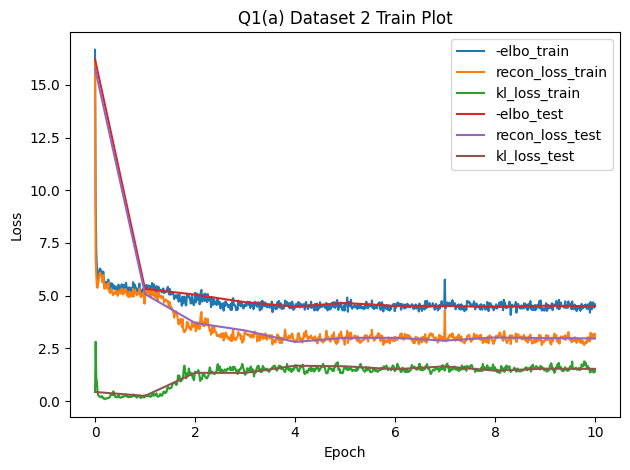

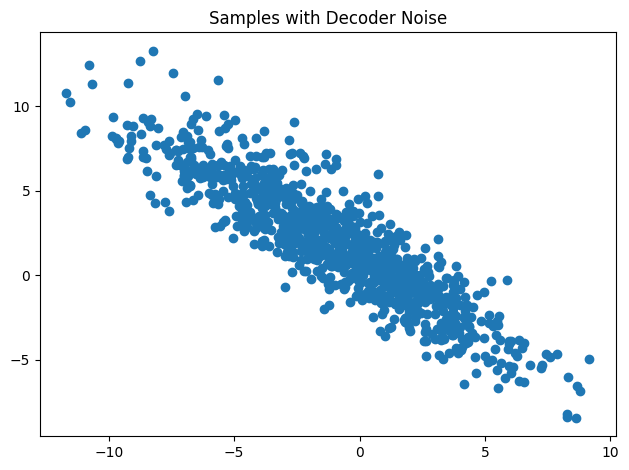

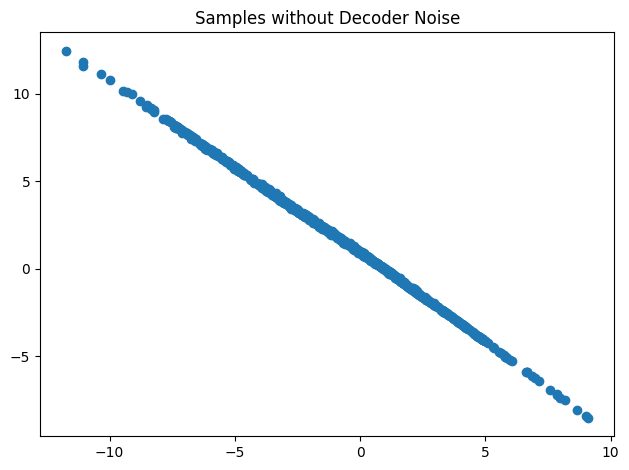

In [9]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


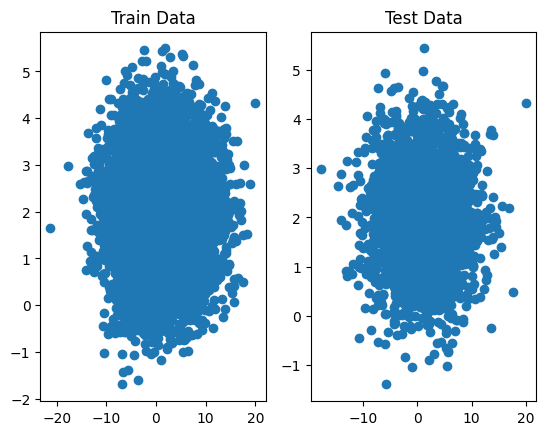

Dataset 2


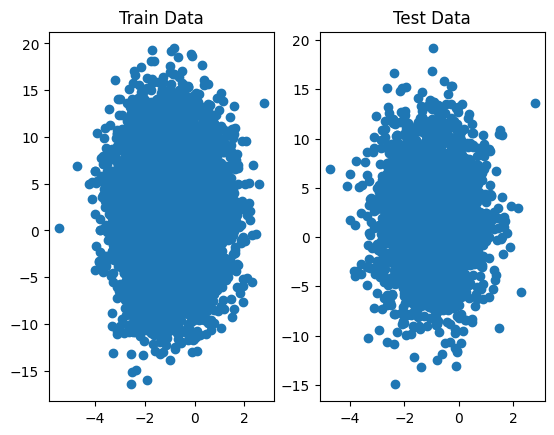

In [10]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 4.4484, Recon Loss: 4.4484, KL Loss: 0.0001


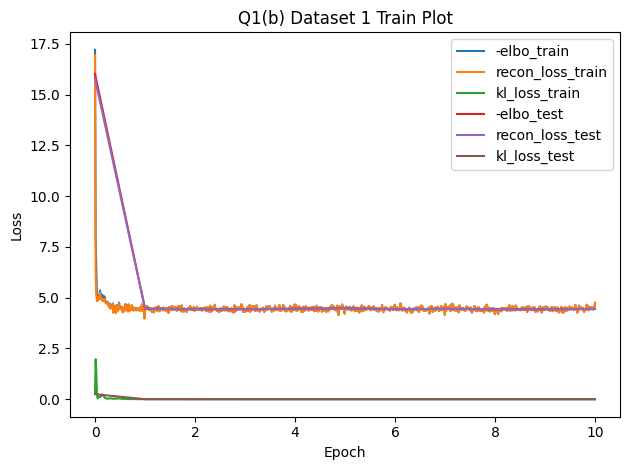

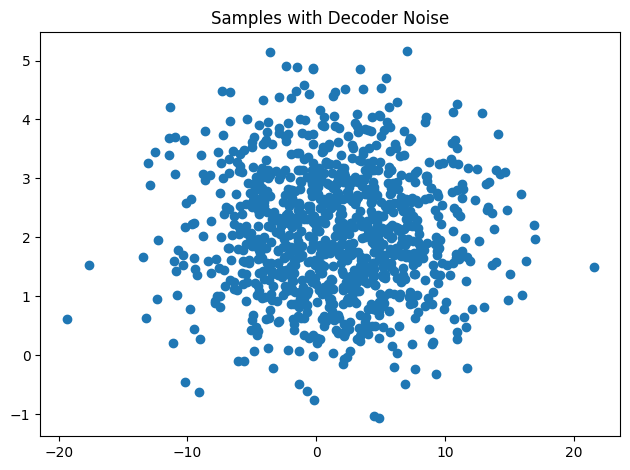

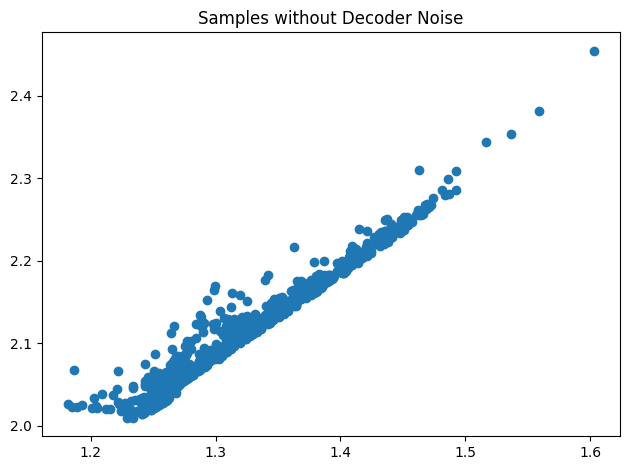

In [11]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4263, Recon Loss: 4.4263, KL Loss: 0.0000


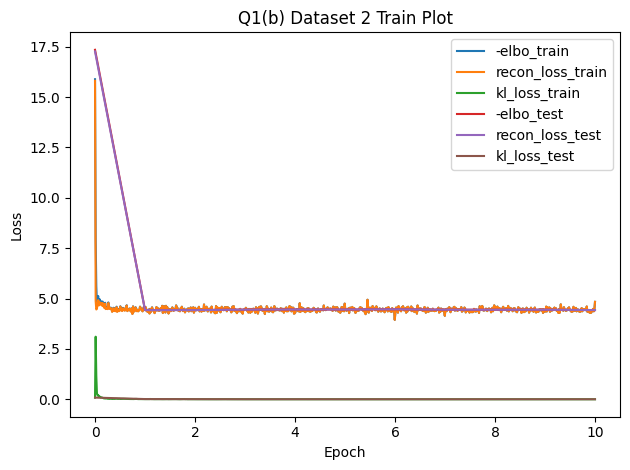

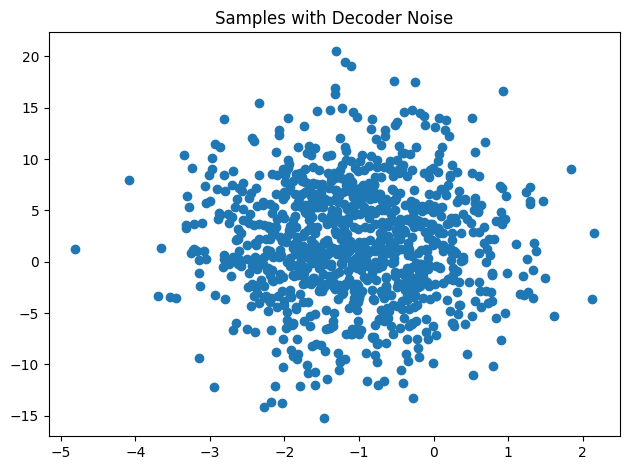

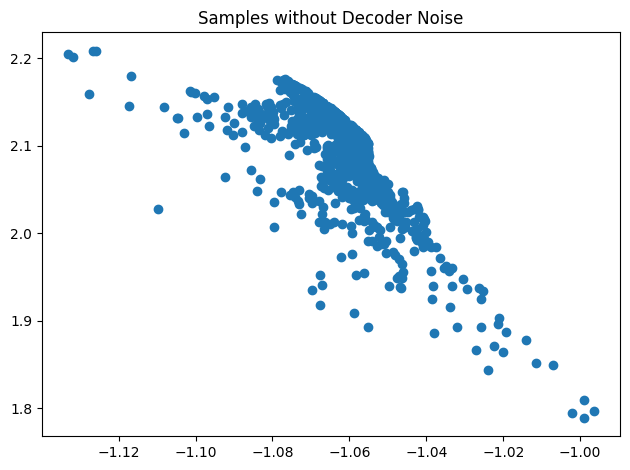

In [12]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

**My Answer**: We can see the latents are more exploited in tha part (a) and less in the part (b). In (a), the data shape requires a gaussian distribution with diagonal covariance distribution on rotated axises, so the vae must learn latents that corresponds to this two axises direction. However, in part (b) the data can already be easily expressed by the $p(x|z)\sim N(x; \mu, \sigma^2)$ model, so the latents are not necessary.

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

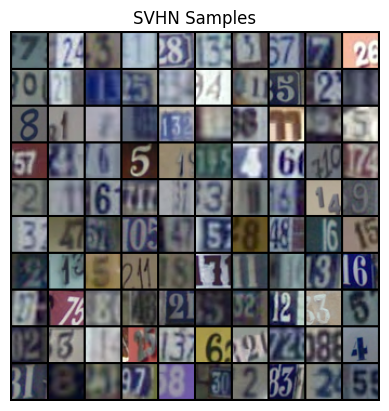

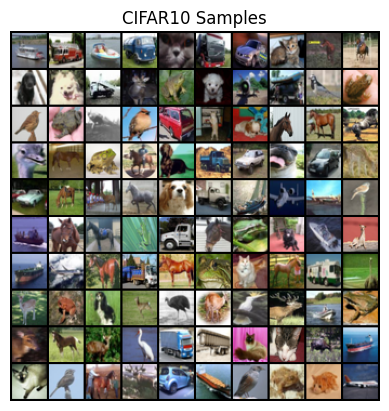

In [13]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [14]:
class ImgVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), # (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # (128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), # (256, 4, 4)
            nn.ReLU(),
            nn.Flatten(1), # (256 * 4 * 4)
            nn.Linear(256 * 4 * 4, latent_dim * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # (128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # (64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1) # (3, 32, 32)
        )

    def encode(self, x):
        z_params = self.encoder(x)
        z_mean, z_log_var = z_params.chunk(2, dim=-1)
        return z_mean, z_log_var

    def decode(self, z):
        x_mean = self.decoder(z)
        return x_mean

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean, x_log_var = self.decode(z)
        x_hat = self.reparameterize(x_mean, x_log_var)
        return x_hat, x_mean, x_log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def loss(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var) # (batch, latent_dim)
        x_mean = self.decode(z).flatten(1) # (batch, 3 * 32 * 32)
        x = x.flatten(1) # (batch, 3 * 32 * 32)
        # KL divergence between approximate posterior and prior
        kl = 0.5 * torch.sum(z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1, dim=-1)
        # reconstruction loss
        # Here we ignore the constant term in the Gaussian distribution
        rcl = 0.5 * torch.mean((x - x_mean) ** 2, dim=-1) # Warn: here we mean over the channel, height and width, which is different from the vanilla VAE
        kl, rcl = kl.mean(), rcl.mean()
        nelbo = kl + rcl # negative elbo
        return nelbo, rcl, kl

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn(n, 16).to(device)
        x_mean = self.decode(z)
        x_hat = x_mean + torch.randn_like(x_mean)
        return x_hat.cpu().detach().numpy()

    @torch.no_grad()
    def reconstruct(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean = self.decode(z)
        x_hat = x_mean + torch.randn_like(x_mean)
        return x_hat.cpu().detach().numpy()

    @torch.no_grad()
    def interpolate(self, x, y):
        """generate 10 interpolations between x and y
        args:
            x: (10, C, H, W)
            y: (10, C, H, W)
        """
        z_mean_x, z_log_var_x = self.encode(x)
        z_mean_y, z_log_var_y = self.encode(y)
        _, C, H, W = x.shape
        result = torch.zeros(10, 10, C, H, W)
        for i in range(10):
            z_mean = z_mean_x + (z_mean_y - z_mean_x) * i / 9
            z_log_var = z_log_var_x + (z_log_var_y - z_log_var_x) * i / 9
            z = self.reparameterize(z_mean, z_log_var)
            x_mean = self.decode(z)
            x_hat = x_mean + torch.randn_like(x_mean)
            result[i] = x_hat
        result = result.permute(1, 0, 2, 3, 4) # To fit with the HW2 helper function
        result = result.reshape(100, C, H, W)
        return result.cpu().detach().numpy()



In [15]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    lr, epochs, batch_size = 0.001, 20, 128
    model = ImgVAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    '''
    The rgbscale and bias should be carefully chosen:
    - if the rgbscale is to small, there will be large noise in the generated image. If it is too large, the gradient may overflow.
    '''
    rgbscale, bias = 1 ,  - 255 / 2
    preprocess, postprocess = preprocessor(rgbscale, bias), postprocessor(rgbscale, bias)
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]

    for epoch in range(epochs):
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo, rcl, kl = model.loss(x)
            # nelbo.backward()
            nelbo.backward()
            optimizer.step()
            record_train.append([nelbo.item(), rcl.item(), kl.item()])
        record_test.append(test_loss(model, test_loader, loss_dim=3))

    samples = model.sample(100)
    samples = postprocess(samples)
    real = test_data[:50].to(device)
    recon = model.reconstruct(real)
    pairs = pair_concate(postprocess(real), postprocess(recon))
    interpolations = postprocess(model.interpolate(test_data[:10].to(device), test_data[10:20].to(device)))

    return np.array(record_train), np.array(record_test), samples, pairs, interpolations

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

**Note**
1. For the vanilla VAE, I think a trouble here is that the recon loss is much greater than the KL loss, thus the posterior distribution is not very close to the priori gaussian.
We can observe this phenomenon from the samples. Although they show some rough shape of digitals, they are still dim and blurred. The sample quality should be improved if we could make the KL divergence smaller.
2. My solution is to add take the mean value over all pixels in the Reconstruction loss to decrease its value, so this implementation is similar to a $\beta VAE$.

Final -ELBO: 239.2002, Recon Loss: 204.8114, KL Loss: 34.3888


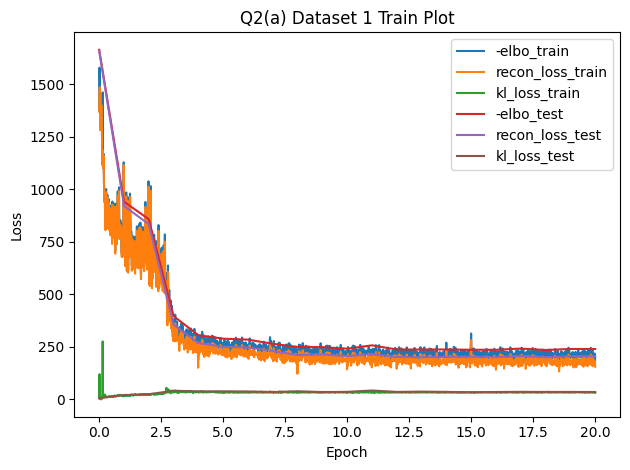

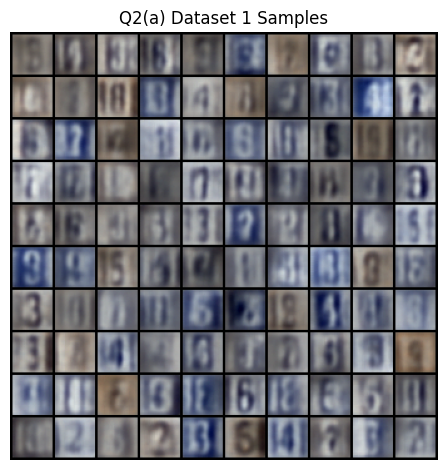

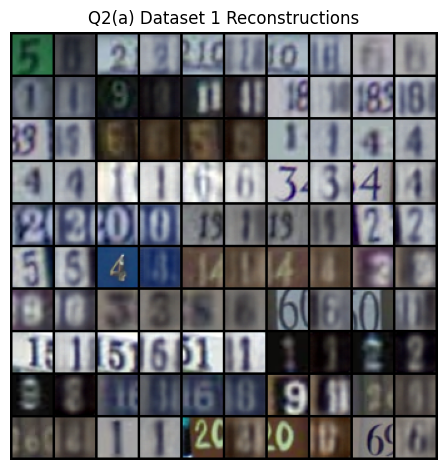

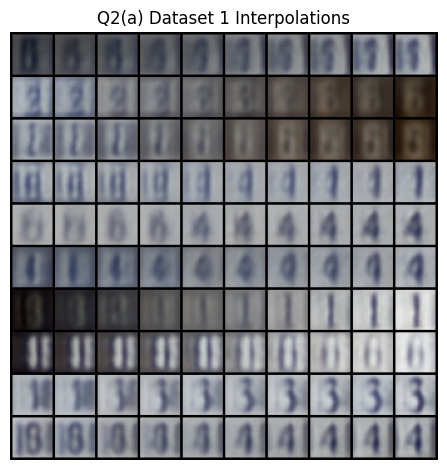

finished in 43.1971s


In [16]:
timer.start()
q2_save_results('a', 1, q2_a)
timer.end()

Final -ELBO: 581.8730, Recon Loss: 542.9289, KL Loss: 38.9441


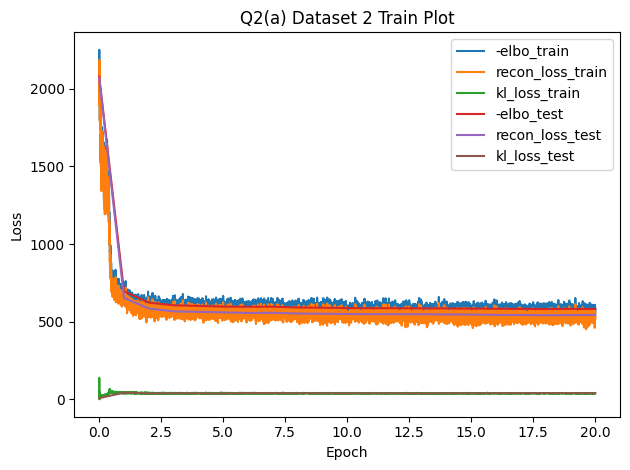

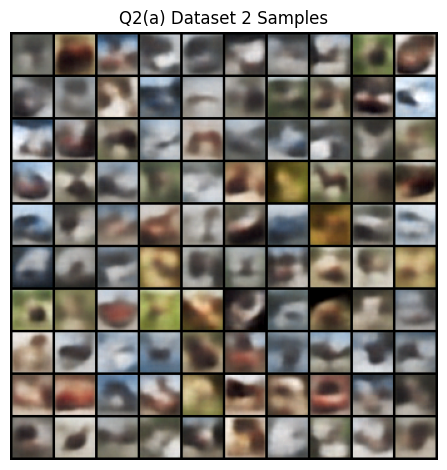

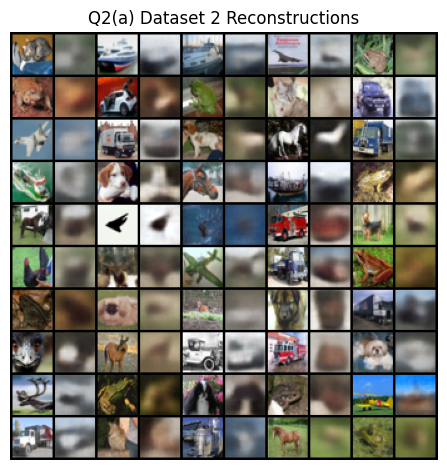

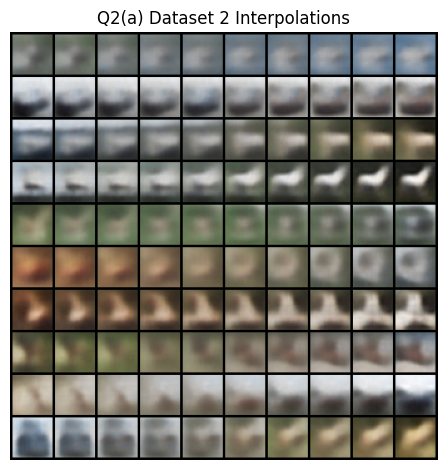

finished in 187.5812s


In [17]:
timer.start()
q2_save_results('a', 2, q2_a)
timer.end()

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

**Note**:
My implementation of hierarchical VAE can be visualized as:
![Hierarchical VAE](./img/H-VAE.png)


In [18]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, channels):
        '''
        Layer normalization accross the channel dimension
        '''
        super().__init__(channels)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

class Hencoder(nn.Module):
    def __init__(self, input_channels=3+12):
        '''
        Encode the image and the z_1 to z_2.
        if the input_channels is 3+12, then the input is the image and z_1,
        otherwise, the input_channels is 3, then the input is the image.
        '''
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1), # [32, 32, 32]
            LayerNorm(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
        )

    def forward(self, x, z=None):
        if z is not None:
            z = F.interpolate(z, size=(x.shape[2], x.shape[3]), mode='nearest')
            x = torch.cat([x, z], dim=1)
        return self.encoder(x)

class Hdecoder(nn.Module):
    def __init__(self):
        '''Decode the z_2 to the image'''
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
        )

    def forward(self, z):
        return self.decoder(z)

class HVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Hencoder(3) # encode the image to z1
        self.rnd_z2 = Hencoder(3+12) # residual normal distribution for z2
        self.priori_z2 = Hencoder(3+12) # priori normal distribution for z2
        self.decoder = Hdecoder()

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def encode(self, x):
        lst = []
        # z1
        z1_params = self.encoder(x)
        z1_mean, z1_log_var = z1_params.chunk(2, dim=1)
        z1 = self.reparameterize(z1_mean, z1_log_var)
        lst.append((z1, z1_mean, z1_log_var))

        # z2
        zeros_x = torch.zeros(x.shape[0], 3, x.shape[2], x.shape[3]).to(device)
        priori_z2_params = self.priori_z2(zeros_x, z1)
        priori_z2_mean, priori_z2_log_var = priori_z2_params.chunk(2, dim=1)
        res_z2_params = self.rnd_z2(x, z1)
        res_z2_mean, res_z2_log_var = res_z2_params.chunk(2, dim=1)
        z2_mean, z2_log_var = res_z2_mean + priori_z2_mean, res_z2_log_var + priori_z2_log_var
        z2 = self.reparameterize(z2_mean, z2_log_var)
        lst.append((z2, priori_z2_mean, priori_z2_log_var, res_z2_mean, res_z2_log_var))
        return lst

    def decode(self, z2):
        return self.decoder(z2)

    def forward(self, x):
        pass

    def loss(self, x):
        z_lst = self.encode(x)
        z1, z1_mean, z1_log_var = z_lst[0]
        z2, _, priori_z2_log_var, res_z2_mean, res_z2_log_var = z_lst[1]
        x_mean = self.decode(z2)
        # KL divergence between approximate posterior and prior
        kl_z1 = 0.5 * torch.sum(z1_mean ** 2 + torch.exp(z1_log_var) - z1_log_var - 1, dim=[1, 2, 3])
        kl_z2 = 0.5 * torch.sum(res_z2_mean ** 2 / torch.exp(priori_z2_log_var) + torch.exp(res_z2_log_var) - res_z2_log_var - 1, dim=[1, 2, 3])
        # reconstruction loss
        rcl = 0.5 * torch.mean((x - x_mean) ** 2, dim=[1, 2, 3]) # Warn: here we mean over the batch, height and width, which is different from the vanilla VAE
        kl_z1, kl_z2, rcl = kl_z1.mean(), kl_z2.mean(), rcl.mean()
        nelbo = kl_z1 + kl_z2 + rcl # negative elbo
        return nelbo, rcl, kl_z1, kl_z2

    @torch.no_grad()
    def sample(self, n):
        z1 = torch.randn(n, 12, 2, 2).to(device)
        zeros_x = torch.zeros(n, 3, 32, 32).to(device)
        priori_z2_params = self.priori_z2(zeros_x, z1)
        priori_z2_mean, priori_z2_log_var = priori_z2_params.chunk(2, dim=1)
        std = torch.exp(0.5 * priori_z2_log_var)
        z2 = priori_z2_mean + torch.randn_like(priori_z2_mean) * std
        x_mean = self.decode(z2)
        return x_mean.cpu().detach().numpy()

    @torch.no_grad()
    def reconstruct(self, x):
        z_lst = self.encode(x)
        z2, _, _, _, _ = z_lst[1]
        x_mean = self.decode(z2)
        return x_mean.cpu().detach().numpy()


    @torch.no_grad()
    def interpolate(self, x, y):
        """generate 10 interpolations between x and y
        args:
            x: (10, C, H, W)
            y: (10, C, H, W)
        """
        x_z_lst = self.encode(x)
        y_z_lst = self.encode(y)
        x_z2 = x_z_lst[1][0]
        y_z2 = y_z_lst[1][0]
        _, C, H, W = x.shape
        result = torch.zeros(10, 10, C, H, W)
        for i in range(10):
            z2 = x_z2 + (y_z2 - x_z2) * i / 9
            x_mean = self.decode(z2)
            x_hat = x_mean + torch.randn_like(x_mean)
            result[i] = x_hat
        result = result.permute(1, 0, 2, 3, 4) # To fit with the HW2 helper function
        result = result.reshape(100, C, H, W)
        return result.cpu().detach().numpy()



In [19]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    lr, epochs, batch_size = 0.001, 40, 128
    model = HVAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    rgbscale, bias = 1,  - 255 / 2
    preprocess, postprocess = preprocessor(rgbscale, bias), postprocessor(rgbscale, bias)
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]

    for epoch in range(epochs):
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo, rcl, kl_z1, kl_z2 = model.loss(x)
            kl = kl_z1 + kl_z2
            nelbo.backward()
            optimizer.step()
            record_train.append([nelbo.item(), rcl.item(), kl.item()])
        record_test.append(test_loss(model, test_loader, loss_dim=3))

    samples = model.sample(100)
    samples = postprocess(samples)
    real = test_data[:50].to(device)
    recon = model.reconstruct(real)
    pairs = pair_concate(postprocess(real), postprocess(recon))
    interpolations = postprocess(model.interpolate(test_data[:10].to(device), test_data[10:20].to(device)))

    return np.array(record_train), np.array(record_test), samples, pairs, interpolations

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

**Note**:
-  In my implementation, I didn't follow the suggesting of fixing the variance of $p(z_2|z_1)$ to 1. And the stability of training is fine.
- I didn't follow the exact KL loss for $z_2$ in NVAE which requires taking an average over different $z_1$ sampled from encoder.

**Comment**:
- The expressive space of hierarchical VAE is larger than the part (a) VAE, however, this also requires a larger number of training epochs to make the model saturates.
- Compared with part (a), hierarchical VAE can achieve smaller KL loss(even with less epochs). Qualitatively speaking, this is perhaps because the latents can vary less to achieve the same reconstruction quality due to the increase of expressive power.

Final -ELBO: 239.0139, Recon Loss: 182.9012, KL Loss: 9.7914


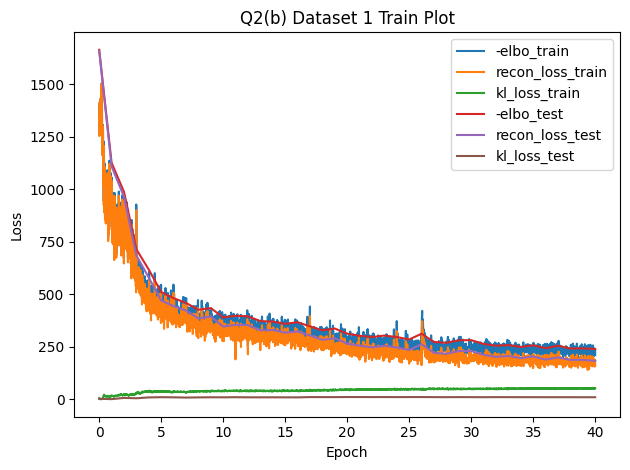

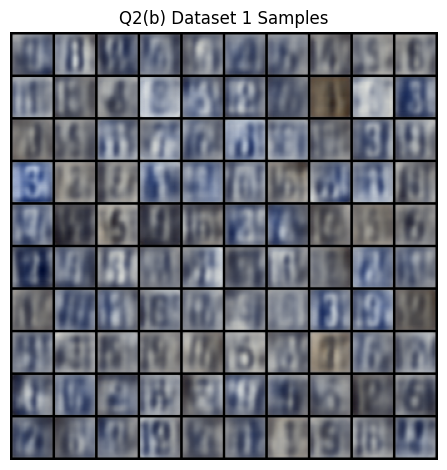

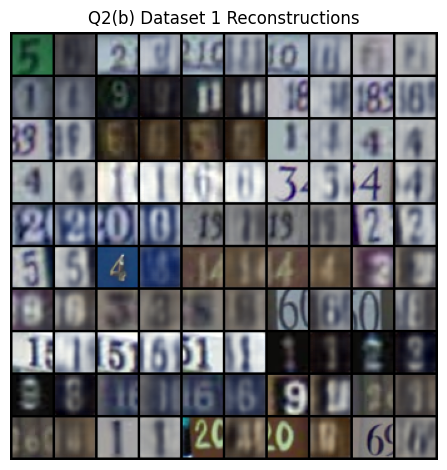

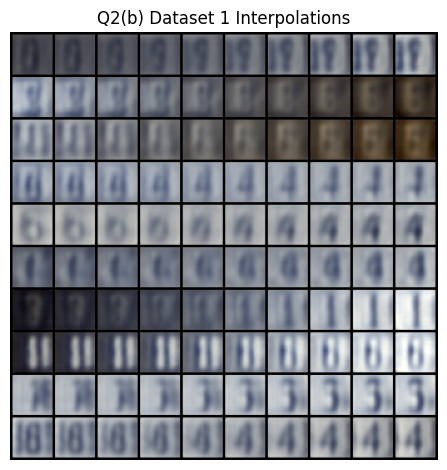

finished in 210.1997s


In [20]:
timer.start()
q2_save_results('b', 1, q2_b)
timer.end()

Final -ELBO: 421.6788, Recon Loss: 345.8602, KL Loss: 0.0084


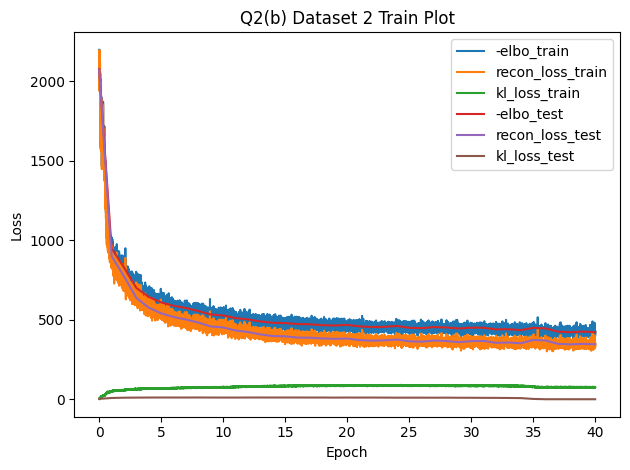

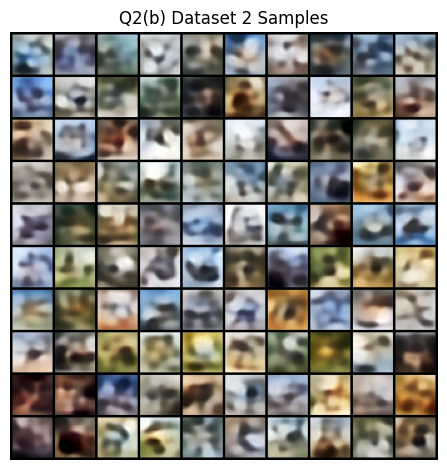

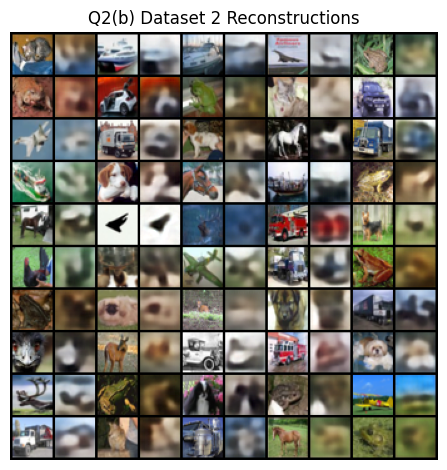

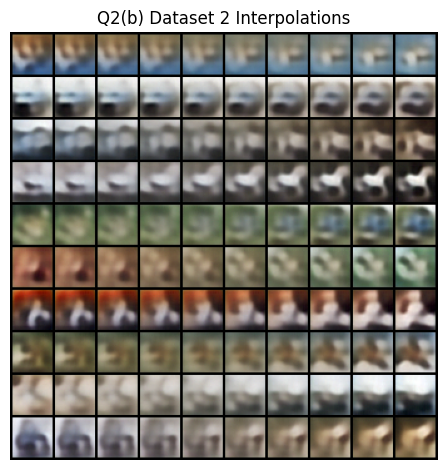

finished in 956.8683s


In [21]:
timer.start()
q2_save_results('b', 2, q2_b)
timer.end()

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

**Note**
- The loss for VQ-VAE is $$L=\underbrace{{\|\mathbf{x}-D(\mathbf{e})\|_{2}^{2}}}_{{\text{reconstruction loss}}}+\underbrace{{\|\mathrm{sg}[E(\mathbf{x})]-\mathbf{e}\|_{2}^{2}}}_{{\mathrm{VQ~loss}}}+\underbrace{{\beta\|E(\mathbf{x})-\mathrm{sg}[\mathbf{e}]\|_{2}^{2}}}_{{\text{commitment loss}}}$$

In [4]:
from torch.nn.modules.batchnorm import BatchNorm2d

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            BatchNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            BatchNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 1, 1, ),
        )

    def forward(self, x):
        return x + self.net(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), # 16 x 16
            BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 4, 2, 1), # 8 x 8
            ResidualBlock(256),
            ResidualBlock(256),
        )

    def forward(self, x):
        return self.net(x) # (B, 256, 8, 8)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 4, 2, 1), # 16 x 16
            BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 3, 4, 2, 1), # 32 x 32
        )

    def forward(self, x):
        return self.net(x)

class LatentQuantizer(nn.Module):
    def __init__(self, K=128, D=256):
        super().__init__()
        self.K = K
        self.D = D
        self.codebook = nn.Parameter(- 1 / K + 2 / K *
            torch.randn((K, D)))

    def forward(self, z):
        z_q = z.permute(0, 2, 3, 1).unsqueeze(-1) # (B, H, W, D, 1)
        distance = z_q - torch.transpose(self.codebook, -2, -1) # (B, H, W, D, K)
        distance = torch.sum(distance ** 2, dim=-2) # (B, H, W, K)
        z_q = torch.argmin(distance, dim=-1) # (B, H, W)
        return z_q # (B, H, W)

    def decode(self, z_q):
        return self.codebook[z_q].permute(0, 3, 1, 2)

class VQVAE(nn.Module):
    def __init__(self, K=128):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.quantizer = LatentQuantizer(K=K, D=256)

    def quantized_encode(self, x):
        z = self.encoder(x) # (B, 256, 8, 8)
        z_q = self.quantizer(z) # (B, 8, 8)
        z_dict = {'z': z, 'z_q': z_q}
        return z_dict

    def decode(self, z_dict):
        z, z_q = z_dict.values()
        z_q = self.quantizer.decode(z_q)
        # straight through estimator
        x_hat = self.decoder((z_q - z).detach() + z)
        return x_hat

    def forward(self, x):
        z_dict = self.quantized_encode(x)
        x_hat = self.decode(z_dict)
        return x_hat

    def loss(self, x, beta=0.25):
        z_dict = self.quantized_encode(x)
        z, z_q = z_dict['z'], z_dict['z_q'] # (B, 256, 8, 8), (B, 8, 8)
        z_q = self.quantizer.decode(z_q) # (B, 256, 8, 8)
        vq_loss = F.mse_loss(z.detach(), z_q)
        cmt_loss = F.mse_loss(z, z_q.detach())
        x_hat = self.decode(z_dict)
        rcl = F.mse_loss(x, x_hat)
        total_loss = rcl + vq_loss + beta * cmt_loss
        loss_dict = {'total_loss': total_loss, 'rcl': rcl, 'vq_loss': vq_loss, 'cmt_loss': cmt_loss}
        return loss_dict

    @torch.no_grad()
    def quantize(self, x):
        z_dict = self.quantized_encode(x)
        z_q = z_dict['z_q']
        return z_q.cpu().detach().numpy()

    @torch.no_grad()
    def sample(self, n, prior_model=None):
        '''just for test, implement transformer based prior later'''
        if prior_model is None:
            z_q = torch.randint(0, 128, (n, 8, 8)).to(device)
        else:
            flatten_z_q = prior_model.sample(n) # (n, 8 * 8)
            z_q = flatten_z_q.reshape(n, 8, 8)
        z_q = self.quantizer.decode(z_q)
        x_hat = self.decoder(z_q)
        return x_hat.cpu().detach().numpy()

    @torch.no_grad()
    def reconstruct(self, x):
        x_hat = self.forward(x)
        return x_hat.cpu().detach().numpy()


Transformer module from hw1.

In [5]:
from my_utils.hw2_utils import TSFM_DataLoader, iGPT

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [8]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    lr, epochs, batch_size, beta = 0.001, 20, 128, 1
    rgb_scale, bias = 2 / 255, - 255 / 2
    preprocess, postprocess = preprocessor(rgb_scale, bias), postprocessor(rgb_scale, bias)
    train_data, test_data = preprocess(train_data), preprocess(test_data)
    model = VQVAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader)]

    # train the VQVAE
    sep = '------------------------------------\n'
    print(f'{sep}start training the VQVAE\n')
    for epoch in range(epochs):
        model.train()
        for i, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            loss_dict = model.loss(x, beta)
            loss = loss_dict['total_loss']
            loss.backward()
            optimizer.step()
            record_train.append(loss.item())
            # if i == 0:
            #     print(f'epoch {epoch} total train loss: {loss.item()}, rcl: {loss_dict["rcl"]}, \
            #           vq_loss: {loss_dict["vq_loss"]}, cmt_loss: {loss_dict["cmt_loss"]}')
            #     print(f'codebook mean and var: {model.quantizer.codebook.mean().item()}, {model.quantizer.codebook.var().item()}')
        record_test.append(test_loss(model, test_loader))


    # train the transformer prior
    L, vocab_size, dmodel, n_head, n_layer = 8 * 8 + 1, 128 + 1, 128, 4, 2
    tsfm = iGPT(L, vocab_size, dmodel, n_head, n_layer).to(device)
    tsfm_train_loader = TSFM_DataLoader(train_data, model, batch_size, shuffle=True, num_workers=0)
    tsfm_test_loader = TSFM_DataLoader(test_data, model, batch_size, shuffle=False, num_workers=0)
    tsfm_record_train, tsfm_record_test = [], [test_loss(tsfm, tsfm_test_loader)]
    tsfm_optimizer = optim.Adam(tsfm.parameters(), lr=lr)

    print(f'{sep}start training the transformer prior\n')
    for epoch in range(epochs):
        tsfm.train()
        for x in tsfm_train_loader:
            x = x.to(device)
            tsfm_optimizer.zero_grad()
            loss = tsfm.loss(x)
            loss.backward()
            tsfm_optimizer.step()
            tsfm_record_train.append(loss.item())
        tsfm_record_test.append(test_loss(tsfm, tsfm_test_loader))

    samples = model.sample(100, tsfm)
    samples = postprocess(samples)
    real = test_data[:50].to(device)
    recon = model.reconstruct(real)
    pairs = pair_concate(postprocess(real), postprocess(recon))

    return np.array(record_train), np.array(record_test), np.array(tsfm_record_train), np.array(tsfm_record_test), samples, pairs


## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

**Note**:
-  Emperically we find that the updation of codebook is slower than that of the $z_e$. So, if we don't add a large enough $\beta$, then the VQ-loss and commit loss varies drastically. In this solution, we choose $\beta=1$.

------------------------------------
start training the VQVAE

------------------------------------
start training the transformer prior

VQ-VAE Final Test Loss: 0.0237
Transformer Prior Final Test Loss: 1.9613


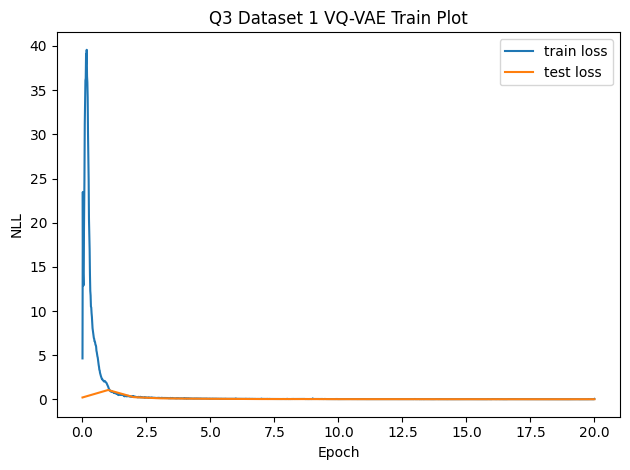

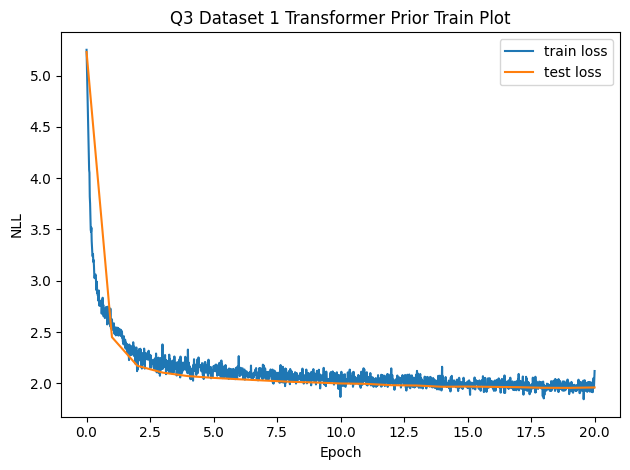

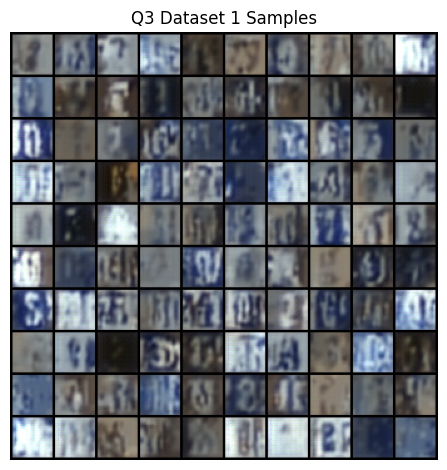

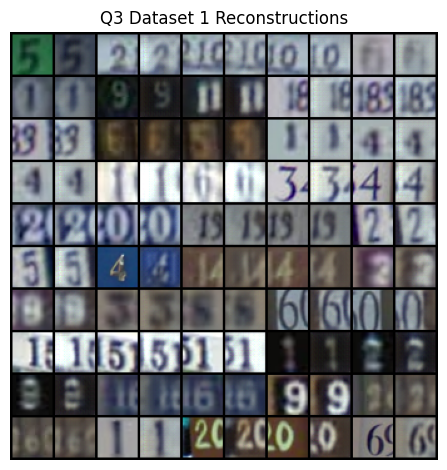

finished in 293.4877s


In [9]:
timer.start()
q3_save_results(1, q3)
timer.end()

------------------------------------
start training the VQVAE

------------------------------------
start training the transformer prior

VQ-VAE Final Test Loss: 0.0467
Transformer Prior Final Test Loss: 2.6257


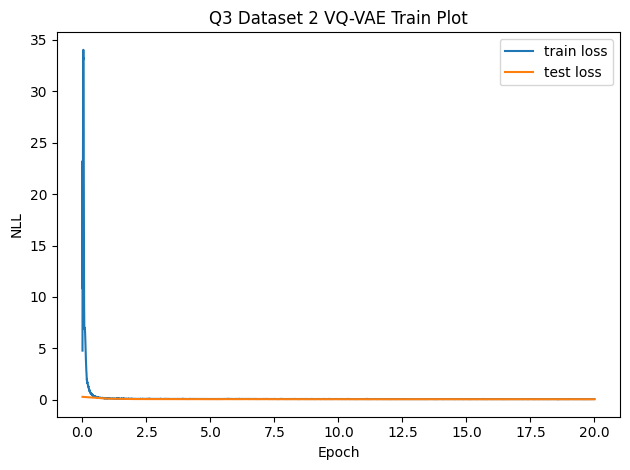

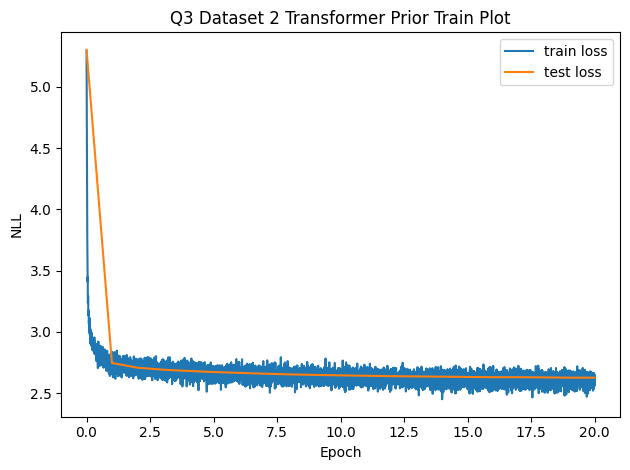

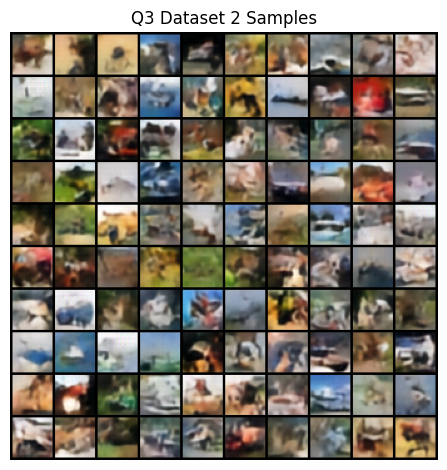

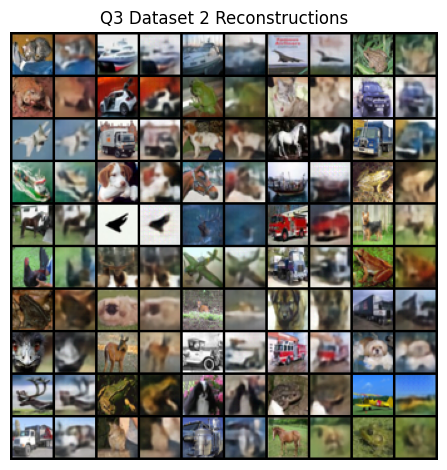

finished in 1285.5931s


In [10]:
timer.start()
q3_save_results(2, q3)
timer.end()

# File Saving Utility


In [11]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def mario_sound():
    from IPython.lib.display import Audio
    import numpy as np

    framerate = 4410
    play_time_seconds = 1
    C, G, E, p = 261.63, 392.00, 329.63, 0.0
    mute_rate = 0.1

    def generatenote(name, relative):
        t = play_time_seconds * relative
        st = np.linspace(0, t * (1 - mute_rate) , int(framerate*t*(1-mute_rate)))
        mt = np.linspace(0, t * mute_rate, int(framerate*t*mute_rate))
        sample = np.concatenate([np.sin(2*np.pi*name*st), np.sin(2*np.pi*mt) ])
        return sample

    def concatenate_notes(notes):

        return np.concatenate([ generatenote(note, r) for note, r in notes])

    audio_data = concatenate_notes([(E,1/8), (E,1/8), (p, 1/8),(E, 1/8),(p, 1/8), (C, 1/8), (E, 1/4), (G, 1/4),(p, 1/4),( G / 2, 1/4)])
    return Audio(audio_data, rate=framerate, autoplay=True)

mario_sound()